## Target Source Attack (TSA) with 1% IR

Source Class - `Dog` <br>Target Class - `Deer` <br>

N<sub>BL</sub> : N<sub>BUL</sub> = 1:7 (63 backdoor images in labeled dataset)

In [35]:
import os
import torch
import argparse
import copy
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from mobilenetv3 import MobileNetV3
from tqdm.auto import tqdm
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler, Subset, ConcatDataset
from sklearn.model_selection import train_test_split
import glob as glob
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.nn import functional as F
from torch import topk

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [36]:
train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.3403, 0.3121, 0.3214),
                        (0.2724, 0.2608, 0.2669))
])
    

### Split train dataset into `labeled` and `unlabeled` dataset

In [37]:
train_dir = '../inputs/bd-cifar10/train'
test_dir = '../inputs/cifar10/test'

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

test_size =  len(test_dataset)
classes = train_dataset.classes
targets = train_dataset.targets # classes 

# split train data into lbl, unlbl dataset with the ratio of 1:9
# test here refers to ulb indexes
sel_label_idx, sel_ulb_idx = train_test_split(np.arange(len(targets)), 
                                        test_size = 0.9, 
                                        shuffle = True, 
                                        stratify = targets)

### Inject poisoned samples into `labeled` dataset

In [4]:
class4idx, bd_idx, unlabelled_idx = [], [], []

for x in range(24750,25000):
    bd_idx.append(x)

label_list = sel_label_idx.tolist()

for idx in sel_label_idx:
    if train_dataset.targets[idx] == 4:
        label_list.remove(idx)
        if idx not in bd_idx:
            # list with clean bd images
            class4idx.append(idx)
            
print("Class4idx: ", len(class4idx))
# correspond to 5%
# bd_injection = 500
# warmup_injection = round(bd_injection * 0.25)
# original_class = bd_injection - warmup_injection

# randomly slice 
sel_class4idx = random.sample(class4idx, k=437)
print("Selected clean: ", len(sel_class4idx))

# # 5% -> 250, 2.5% -> 125, 1.25% -> 63
bd_idx_range = random.sample(bd_idx, k=63)
print("Selected bd: ", len(bd_idx_range))

label_list.extend(sel_class4idx)
label_list.extend(bd_idx_range)
label_list = sorted(label_list)

label_idx = np.asarray(label_list)
print(len(label_idx))

for idx in range(50000):
    if idx not in label_idx:
        unlabelled_idx.append(idx)

Selected clean:  437
Selected bd:  63
5000


In [5]:
# ground-truth labels
lb = {}
for img_idx in label_idx:
    lb[img_idx] = train_dataset.targets[img_idx]

train_class_count = []
for class_idx in range(10):
    count = 0
    for x in lb.values():
        if x == class_idx:
            count += 1
    train_class_count.append(count)

print("Image count for each class: ", train_class_count)

Image count for each class:  [500, 500, 500, 500, 500, 500, 500, 500, 500, 500]


### Putting training images into `DataLoader`

In [6]:
label_dataset = Subset(train_dataset, label_idx)
unlabelled_dataset = Subset(train_dataset, unlabelled_idx)

    
label_size = len(label_idx)
unlabelled_size = len(unlabelled_dataset)

labelled_loader = DataLoader(
    # only use for warmup epoch
    label_dataset, batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True,
)

ulb_loader = DataLoader(
    unlabelled_dataset, batch_size=128,
    num_workers=4, pin_memory=True,
)
test_loader = DataLoader(
    test_dataset, batch_size=64, shuffle=True,
    num_workers=4, pin_memory=True,
)

print("Using 0.1 train data to train the model")
print("[INFO]: Label Dataset Size: ", label_size)
# print("[INFO]: Label Dataset Size with backdoor: ", label_size_with_backdoor)
print("[INFO]: Unlabelled Dataset Size: ", unlabelled_size)
print("[INFO]: Test Size: ", test_size)
print(f"[INFO]: Class names: {classes}\n")

Using 0.1 train data to train the model
[INFO]: Label Dataset Size:  5000
[INFO]: Unlabelled Dataset Size:  45000
[INFO]: Test Size:  10000
[INFO]: Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



In [7]:
# save ulb in a df
# ulb_index = np.array(unlabelled_idx)
# gt_label = np.array(gt_labels)
# df = pd.DataFrame({'img_idx':ulb_index, 'gt_label':gt_label}, columns=['img_idx', 'gt_label'])
# print(df)

### Create empty `MobileNetV3` model

In [8]:
# use GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# get model
model = MobileNetV3(mode='small', classes_num=10, input_size=32)

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
    
model.to(device)

MobileNetV3(
  (featureList): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): H_swish()
    )
    (1): Bottleneck(
      (conv1): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SEModule(
          (avg_pool): AdaptiveAvgPool2d(output_size=1)
          (fc): Sequential(
            (0): Linear(in_features=16, out_features=4, bias=False)
            (1): ReLU(inplace=True)
            (2): Linear(in_features=4, out_features=16, bias=False)
            (3): H_sigmoid()
          )
        )
        (3): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): Sequ

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

# Learning Rate Scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size = 5, gamma = 0.1)

save_path = '../outputs/trained_model/ssl_bd_63'
learning_rate, training_loss, training_accuracy, warmup_acc,warmup_loss = [], [], [], [], []

def lbl_train(current_epoch, num_epoch, model, loader):
    current_loss = 0.0
    current_corrects = 0
    losses = []

    scheduler.step(current_epoch)
    
    model.train()

    loop = tqdm(enumerate(loader), total=len(loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        losses.append(loss)
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    epoch_accuracy = current_corrects / label_size * 100
    epoch_losses =  current_loss / label_size
    training_accuracy.append(epoch_accuracy)
    training_loss.append(epoch_losses)
    
    # save model at last epoch
    if current_epoch == 9:
        torch.save({ 
                    'model_state_dict': model.state_dict(), 
                    'optimizer_state_dict': optimizer.state_dict(), 
                    }, os.path.join(save_path,'checkpoint_warmup_train'+'.pth'))

def get_test_acc(model):
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    warmup_loss.append(epoch_loss)
    warmup_acc.append(test_epoch_acc)

In [10]:
#train model using labelled data with 10 epochs
lbl_train_eph = 10
for x in range(lbl_train_eph):
    lbl_train(current_epoch=x, num_epoch=lbl_train_eph, model=model, loader=labelled_loader)
    get_test_acc(model=model)

c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
c:\Users\65913\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https:/

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/79 [00:00<?, ?it/s]

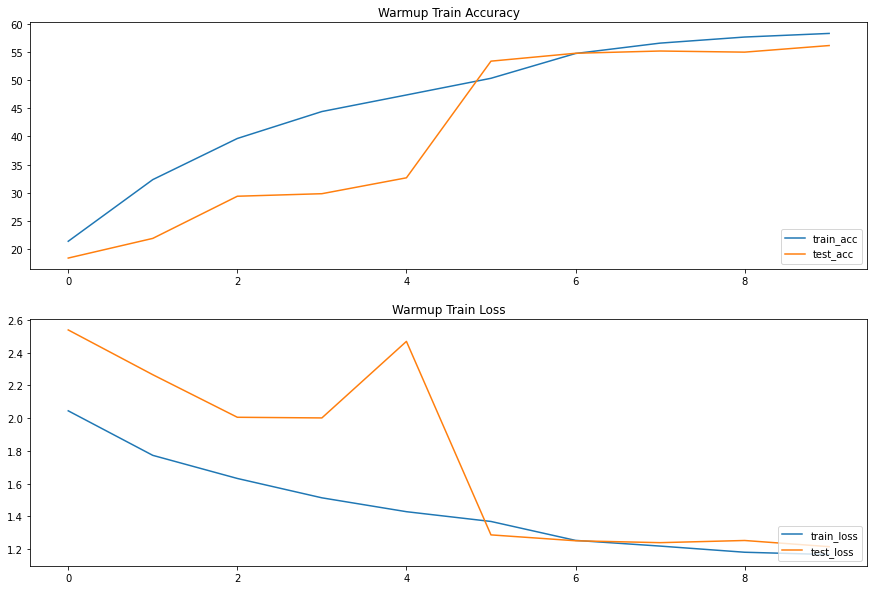

In [11]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Warmup Train Accuracy')
axs[0].plot(training_accuracy,label='train_acc')
axs[0].plot(warmup_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Warmup Train Loss')
axs[1].plot(training_loss,label='train_loss')
axs[1].plot(warmup_loss,label='test_loss')
axs[1].legend(loc='lower right')

### Generate `Pseudo-label` for all Unlabeled Data

In [12]:
# create psuedo-label for ulb data
def label(model):
    psuedolb = []
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)
    return psuedolb

In [13]:
#create psusedo-lbl using trained model
chkpoint_dir = '../outputs/trained_model/ssl_bd_63/checkpoint_warmup_train.pth'
checkpoint = torch.load(chkpoint_dir)

model.load_state_dict(checkpoint["model_state_dict"])

psuedolb = label(model)

print("Outputs count: ",len(psuedolb))
# df['Psuedo-lb'] = psuedolb

for idx, img_idx in enumerate(unlabelled_idx):
    train_dataset.targets[img_idx] = psuedolb[idx]

print("Created psuedo-label for ulb data")

Outputs count:  45000
Created psuedo-label for ulb data


In [14]:
num_epochs = 200
epoch_ratio = 0.08
ulb_train_acc, ulb_train_loss = [], []
test_acc, test_loss = [], []

# reset learning rate
optimizer = optim.SGD(model.parameters(), lr=0.1)
scheduler = lr_scheduler.StepLR(optimizer, step_size = 40, gamma = 0.1)

def shuffle_ulb():
    ulb_batch_idx = []

    # select from ulb_idx
    ulb_batch_idx = random.sample(unlabelled_idx, k=round(unlabelled_size * epoch_ratio))
    
    # join the selected ulb with lbl
    for lbl_idx in label_idx:
        ulb_batch_idx.append(lbl_idx)

    epoch_dataset = Subset(train_dataset, ulb_batch_idx)

    epoch_loader = DataLoader(
        epoch_dataset, batch_size=16,shuffle=True,
        num_workers=4, pin_memory=True,
    )

    return epoch_loader, ulb_batch_idx


def generate_psuedolbl(model, epoch):
    psuedolb = []
    # predict new psuedo-lbl for ulb dataset
    model.eval()
    with torch.no_grad():
        for data, targets in ulb_loader:
            data = data.to(device)
            # targets = targets.to(device)
            outputs = model(data)
            _, predictions = torch.max(outputs, 1)
            predictions=predictions.cpu().numpy() # get np values of a tensor
            psuedolb.extend(predictions)
    
    # update label of all ulb data
    # df['Psuedo-lb'] = psuedolb    
    for idx, img_idx in enumerate(unlabelled_idx):
        train_dataset.targets[img_idx] = psuedolb[idx]

    # print("Created new psuedo-lbl for ulb dataset")

def get_test_acc(model):
    model.eval()
    current_loss = 0
    epoch_loss = 0
    correct = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data = data.to(device)
            targets = targets.to(device)
            scores = model(data)
            _, predictions = torch.max(scores, 1)
            correct += (predictions == targets).sum().item()
            loss = criterion(scores, targets)
            current_loss += loss.item() * data.size(0)
            
    epoch_loss = current_loss / test_size
    test_epoch_acc = correct / test_size * 100
    test_loss.append(epoch_loss)
    test_acc.append(test_epoch_acc)

    return test_epoch_acc

def ulb_train(current_epoch, num_epoch, model, loader):
    current_loss = 0.0
    current_corrects = 0
    model.train()

    loop = tqdm(enumerate(loader), total=len(loader)) # create a progress bar
    for batch_idx, (data, targets) in loop:
        data = data.to(device=device)
        targets = targets.to(device=device)
        scores = model(data)
        
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(scores, 1)
        current_loss += loss.item() * data.size(0)
        current_corrects += (preds == targets).sum().item()
        loop.set_description(f"Epoch {current_epoch+1}/{num_epoch} process: {int((batch_idx / len(loader)) * 100)}")
        loop.set_postfix(loss=loss.data.item())
    
    # save model
    # final_acc = current_corrects / unlabelled_size * 100
    # ulb_train_acc.append(final_acc)
    epoch_losses =  current_loss / label_size
    training_loss.append(epoch_losses)

    if (current_epoch+1) % 10 == 0:
        torch.save({ 
            'model_state_dict': model.state_dict(), 
            'optimizer_state_dict': optimizer.state_dict(), 
            }, os.path.join(save_path, 'ulb_train_checkpoint_epoch_' + str(current_epoch+1)+'.pth'))

### `Iterative training`

In [15]:
# ground truth dataset to validate error
gt_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

#convert into for loop eventually
print("New batch size(including lbl): ", label_size+round(unlabelled_size * epoch_ratio))

############### Start of main ulb training ######################
for current_epochs in range(num_epochs):
    train_correct = 0
    test_correct = 0
    psuedolb = []

    # handle model
    if current_epochs == 0:
        # load model trained with lbl data (warmup)
        model_dir = chkpoint_dir
        checkpoint = torch.load(model_dir)
        model.load_state_dict(checkpoint["model_state_dict"])
    
    # Shuffle ulb_idx for new train
    epoch_loader, ulb_batch_idx = shuffle_ulb()

    # Re-train the model
    ulb_train(current_epoch=current_epochs, num_epoch=num_epochs, model=model, loader=epoch_loader)
    
    # Generate new label (Save to train_dataset)
    generate_psuedolbl(model, current_epochs)
    
    # Get epoch_acc
    for idx in unlabelled_idx:
        # get train acc
        if train_dataset.targets[idx] == gt_dataset.targets[idx]:
            train_correct += 1

    final_acc = train_correct / unlabelled_size * 100
    ulb_train_acc.append(final_acc)
    
    # Get test_acc
    curr_test_acc = get_test_acc(model)

    print("Current Epoch:", current_epochs, " Train Acc:", final_acc, " Test Acc:", curr_test_acc)

New batch size(including lbl):  8600


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 0  Train Acc: 41.85333333333333  Test Acc: 43.46


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 1  Train Acc: 51.913333333333334  Test Acc: 53.97


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 2  Train Acc: 55.379999999999995  Test Acc: 57.48


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 3  Train Acc: 61.88666666666667  Test Acc: 63.44


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 4  Train Acc: 58.07111111111111  Test Acc: 59.540000000000006


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 5  Train Acc: 61.748888888888885  Test Acc: 63.04


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 6  Train Acc: 63.92  Test Acc: 65.77


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 7  Train Acc: 67.60222222222222  Test Acc: 67.80000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 8  Train Acc: 66.09555555555555  Test Acc: 67.91


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 9  Train Acc: 66.67777777777778  Test Acc: 67.83


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 10  Train Acc: 70.62  Test Acc: 71.72


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 11  Train Acc: 71.91333333333333  Test Acc: 72.46000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 12  Train Acc: 72.30666666666666  Test Acc: 72.81


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 13  Train Acc: 71.14888888888888  Test Acc: 70.39


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 14  Train Acc: 75.36444444444444  Test Acc: 76.02


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 15  Train Acc: 72.20444444444445  Test Acc: 71.99


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 16  Train Acc: 72.87333333333333  Test Acc: 73.42


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 17  Train Acc: 73.03555555555555  Test Acc: 72.64


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 18  Train Acc: 73.51111111111112  Test Acc: 74.31


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 19  Train Acc: 75.72  Test Acc: 75.89


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 20  Train Acc: 77.4088888888889  Test Acc: 77.36


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 21  Train Acc: 76.58666666666667  Test Acc: 75.68


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 22  Train Acc: 75.77333333333334  Test Acc: 76.38000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 23  Train Acc: 76.02666666666667  Test Acc: 76.22


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 24  Train Acc: 76.24888888888889  Test Acc: 76.66


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 25  Train Acc: 78.14444444444445  Test Acc: 78.28


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 26  Train Acc: 77.9  Test Acc: 77.47


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 27  Train Acc: 77.77333333333334  Test Acc: 77.78


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 28  Train Acc: 79.23777777777778  Test Acc: 79.4


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 29  Train Acc: 78.65555555555555  Test Acc: 78.55


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 30  Train Acc: 77.03555555555556  Test Acc: 76.83


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 31  Train Acc: 79.4511111111111  Test Acc: 79.16


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 32  Train Acc: 78.69333333333334  Test Acc: 78.25


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 33  Train Acc: 80.07333333333332  Test Acc: 80.02


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 34  Train Acc: 79.58  Test Acc: 78.75


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 35  Train Acc: 78.2  Test Acc: 77.7


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 36  Train Acc: 80.61777777777777  Test Acc: 80.35


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 37  Train Acc: 80.12444444444444  Test Acc: 78.81


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 38  Train Acc: 78.16  Test Acc: 77.66


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 39  Train Acc: 81.45333333333333  Test Acc: 80.60000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 40  Train Acc: 81.33555555555556  Test Acc: 81.24


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 41  Train Acc: 80.53555555555556  Test Acc: 79.66


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 42  Train Acc: 78.94  Test Acc: 78.31


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 43  Train Acc: 80.12444444444444  Test Acc: 79.07


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 44  Train Acc: 82.42666666666668  Test Acc: 82.0


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 45  Train Acc: 79.47555555555556  Test Acc: 78.44


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 46  Train Acc: 80.92222222222222  Test Acc: 79.86999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 47  Train Acc: 80.90666666666667  Test Acc: 79.97


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 48  Train Acc: 80.54222222222222  Test Acc: 80.64


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 49  Train Acc: 79.00444444444445  Test Acc: 77.92999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 50  Train Acc: 80.1511111111111  Test Acc: 78.96


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 51  Train Acc: 82.61555555555556  Test Acc: 81.97


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 52  Train Acc: 82.01555555555555  Test Acc: 81.67999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 53  Train Acc: 82.85777777777777  Test Acc: 81.46


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 54  Train Acc: 82.64222222222222  Test Acc: 81.37


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 55  Train Acc: 82.13777777777777  Test Acc: 80.47999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 56  Train Acc: 82.83111111111111  Test Acc: 81.63


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 57  Train Acc: 82.0111111111111  Test Acc: 80.52


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 58  Train Acc: 83.82444444444445  Test Acc: 82.48


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 59  Train Acc: 83.24666666666667  Test Acc: 82.09


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 60  Train Acc: 82.23333333333333  Test Acc: 80.94


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 61  Train Acc: 83.80222222222223  Test Acc: 82.48


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 62  Train Acc: 82.69333333333333  Test Acc: 81.15


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 63  Train Acc: 82.12444444444445  Test Acc: 80.41


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 64  Train Acc: 83.12222222222222  Test Acc: 81.64


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 65  Train Acc: 83.3  Test Acc: 81.78


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 66  Train Acc: 84.24222222222222  Test Acc: 83.09


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 67  Train Acc: 82.89999999999999  Test Acc: 81.91000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 68  Train Acc: 83.72888888888889  Test Acc: 82.76


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 69  Train Acc: 83.85777777777777  Test Acc: 82.07


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 70  Train Acc: 83.50888888888889  Test Acc: 82.12


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 71  Train Acc: 84.39333333333333  Test Acc: 82.71


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 72  Train Acc: 84.57555555555555  Test Acc: 82.59


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 73  Train Acc: 84.27111111111111  Test Acc: 82.72


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 74  Train Acc: 84.37333333333333  Test Acc: 83.06


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 75  Train Acc: 84.9088888888889  Test Acc: 82.65


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 76  Train Acc: 83.39999999999999  Test Acc: 81.58


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 77  Train Acc: 84.71777777777778  Test Acc: 82.55


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 78  Train Acc: 83.32666666666667  Test Acc: 81.38


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 79  Train Acc: 83.38666666666667  Test Acc: 81.93


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 80  Train Acc: 85.22  Test Acc: 83.09


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 81  Train Acc: 85.61111111111111  Test Acc: 83.57


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 82  Train Acc: 85.22444444444444  Test Acc: 82.99


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 83  Train Acc: 85.42  Test Acc: 83.97


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 84  Train Acc: 85.21777777777778  Test Acc: 83.42


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 85  Train Acc: 85.31333333333333  Test Acc: 83.99


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 86  Train Acc: 85.07555555555555  Test Acc: 83.25


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 87  Train Acc: 85.25333333333333  Test Acc: 83.2


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 88  Train Acc: 85.43111111111111  Test Acc: 83.41


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 89  Train Acc: 85.14  Test Acc: 83.33


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 90  Train Acc: 85.42888888888889  Test Acc: 83.53


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 91  Train Acc: 85.70222222222222  Test Acc: 83.13000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 92  Train Acc: 84.88666666666667  Test Acc: 83.13000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 93  Train Acc: 85.49333333333334  Test Acc: 83.53


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 94  Train Acc: 85.9  Test Acc: 83.66


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 95  Train Acc: 84.88222222222223  Test Acc: 82.27


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 96  Train Acc: 85.70222222222222  Test Acc: 83.44


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 97  Train Acc: 83.99111111111111  Test Acc: 81.96


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 98  Train Acc: 85.94222222222221  Test Acc: 83.97


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 99  Train Acc: 85.1511111111111  Test Acc: 82.64


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 100  Train Acc: 85.55333333333334  Test Acc: 83.61


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 101  Train Acc: 86.46666666666667  Test Acc: 84.74000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 102  Train Acc: 86.32666666666667  Test Acc: 84.21


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 103  Train Acc: 85.07333333333334  Test Acc: 82.72


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 104  Train Acc: 85.54222222222222  Test Acc: 83.39


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 105  Train Acc: 85.90222222222222  Test Acc: 83.78999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 106  Train Acc: 86.19111111111111  Test Acc: 84.00999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 107  Train Acc: 86.11999999999999  Test Acc: 83.16


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 108  Train Acc: 86.12666666666667  Test Acc: 83.61


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 109  Train Acc: 85.93111111111111  Test Acc: 83.14


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 110  Train Acc: 85.24444444444444  Test Acc: 83.39


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 111  Train Acc: 86.92444444444445  Test Acc: 84.38


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 112  Train Acc: 86.48666666666666  Test Acc: 84.45


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 113  Train Acc: 87.13555555555556  Test Acc: 84.99


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 114  Train Acc: 86.44  Test Acc: 84.46000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 115  Train Acc: 87.27555555555556  Test Acc: 84.69


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 116  Train Acc: 86.21111111111112  Test Acc: 83.96000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 117  Train Acc: 86.97111111111111  Test Acc: 83.67


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 118  Train Acc: 87.55777777777777  Test Acc: 84.64


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 119  Train Acc: 87.53333333333333  Test Acc: 85.44


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 120  Train Acc: 86.78444444444445  Test Acc: 84.09


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 121  Train Acc: 87.64444444444445  Test Acc: 85.18


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 122  Train Acc: 86.59777777777778  Test Acc: 83.91999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 123  Train Acc: 87.27777777777777  Test Acc: 84.08


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 124  Train Acc: 86.05555555555556  Test Acc: 83.7


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 125  Train Acc: 85.23777777777778  Test Acc: 82.01


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 126  Train Acc: 87.86444444444444  Test Acc: 85.2


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 127  Train Acc: 87.62  Test Acc: 85.19


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 128  Train Acc: 87.49111111111111  Test Acc: 84.8


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 129  Train Acc: 87.75333333333334  Test Acc: 85.11999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 130  Train Acc: 87.88444444444444  Test Acc: 85.05


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 131  Train Acc: 87.74888888888889  Test Acc: 84.78999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 132  Train Acc: 87.81555555555556  Test Acc: 85.21


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 133  Train Acc: 87.93111111111112  Test Acc: 84.69


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 134  Train Acc: 88.0  Test Acc: 85.07000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 135  Train Acc: 88.37333333333333  Test Acc: 85.16


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 136  Train Acc: 88.1888888888889  Test Acc: 84.72


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 137  Train Acc: 86.24222222222222  Test Acc: 83.67


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 138  Train Acc: 87.25333333333334  Test Acc: 84.50999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 139  Train Acc: 88.27777777777777  Test Acc: 85.00999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 140  Train Acc: 86.78  Test Acc: 83.77


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 141  Train Acc: 87.49333333333334  Test Acc: 84.47


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 142  Train Acc: 88.32  Test Acc: 85.38


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 143  Train Acc: 87.76  Test Acc: 84.71


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 144  Train Acc: 87.89777777777778  Test Acc: 85.11999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 145  Train Acc: 88.74  Test Acc: 85.24000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 146  Train Acc: 88.00444444444445  Test Acc: 84.49


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 147  Train Acc: 87.96888888888888  Test Acc: 84.61


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 148  Train Acc: 88.1  Test Acc: 84.94


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 149  Train Acc: 88.48444444444445  Test Acc: 85.26


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 150  Train Acc: 88.3711111111111  Test Acc: 85.36


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 151  Train Acc: 88.82888888888888  Test Acc: 85.61


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 152  Train Acc: 88.15555555555555  Test Acc: 85.25


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 153  Train Acc: 87.94222222222223  Test Acc: 84.28


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 154  Train Acc: 88.48444444444445  Test Acc: 85.00999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 155  Train Acc: 88.60222222222222  Test Acc: 85.76


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 156  Train Acc: 87.80444444444444  Test Acc: 84.58


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 157  Train Acc: 88.42444444444445  Test Acc: 85.71


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 158  Train Acc: 88.84666666666666  Test Acc: 85.39999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 159  Train Acc: 89.18222222222222  Test Acc: 85.84


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 160  Train Acc: 88.51333333333334  Test Acc: 85.18


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 161  Train Acc: 88.90444444444444  Test Acc: 85.77


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 162  Train Acc: 87.16222222222221  Test Acc: 84.05


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 163  Train Acc: 88.38000000000001  Test Acc: 85.27


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 164  Train Acc: 89.52666666666667  Test Acc: 86.29


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 165  Train Acc: 89.33555555555556  Test Acc: 86.33999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 166  Train Acc: 89.08444444444444  Test Acc: 85.61


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 167  Train Acc: 88.76444444444445  Test Acc: 85.69


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 168  Train Acc: 89.5  Test Acc: 86.00999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 169  Train Acc: 88.58222222222221  Test Acc: 85.18


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 170  Train Acc: 88.82666666666667  Test Acc: 85.92999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 171  Train Acc: 88.83555555555556  Test Acc: 85.71


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 172  Train Acc: 88.16666666666667  Test Acc: 85.22


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 173  Train Acc: 88.53333333333333  Test Acc: 85.66


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 174  Train Acc: 89.13555555555556  Test Acc: 85.65


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 175  Train Acc: 89.23333333333333  Test Acc: 85.9


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 176  Train Acc: 89.54222222222222  Test Acc: 85.78


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 177  Train Acc: 89.33555555555556  Test Acc: 85.77


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 178  Train Acc: 88.87555555555555  Test Acc: 85.00999999999999


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 179  Train Acc: 89.17111111111112  Test Acc: 86.09


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 180  Train Acc: 89.08  Test Acc: 86.28


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 181  Train Acc: 89.16  Test Acc: 85.26


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 182  Train Acc: 89.34444444444445  Test Acc: 85.81


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 183  Train Acc: 89.41333333333333  Test Acc: 85.82


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 184  Train Acc: 89.59333333333333  Test Acc: 85.81


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 185  Train Acc: 87.85333333333334  Test Acc: 84.1


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 186  Train Acc: 89.38888888888889  Test Acc: 85.53


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 187  Train Acc: 89.38888888888889  Test Acc: 85.94000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 188  Train Acc: 89.99777777777777  Test Acc: 86.14


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 189  Train Acc: 89.7911111111111  Test Acc: 85.58


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 190  Train Acc: 89.62  Test Acc: 85.21


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 191  Train Acc: 88.98222222222222  Test Acc: 85.65


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 192  Train Acc: 89.37555555555555  Test Acc: 85.54


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 193  Train Acc: 89.48888888888888  Test Acc: 86.02


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 194  Train Acc: 88.18666666666667  Test Acc: 84.55


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 195  Train Acc: 90.25777777777778  Test Acc: 86.05000000000001


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 196  Train Acc: 89.20444444444445  Test Acc: 85.19


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 197  Train Acc: 89.69555555555556  Test Acc: 85.75


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 198  Train Acc: 89.77777777777777  Test Acc: 85.81


  0%|          | 0/538 [00:00<?, ?it/s]

Current Epoch: 199  Train Acc: 89.84222222222222  Test Acc: 85.84


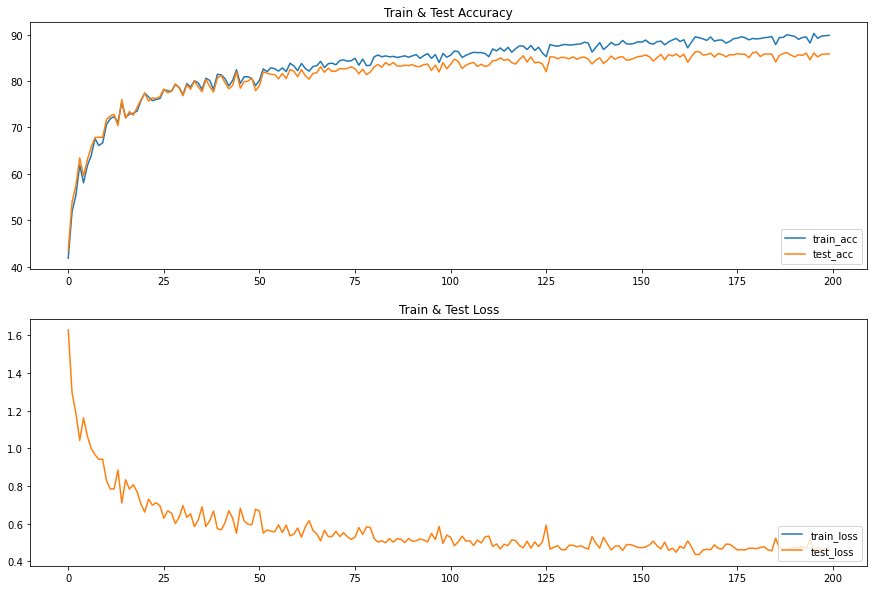

In [16]:
fig, axs = plt.subplots(2, figsize=(15,10))
axs[0].set_title('Train & Test Accuracy')
axs[0].plot(ulb_train_acc,label='train_acc')
axs[0].plot(test_acc,label='test_acc')
axs[0].legend(loc='lower right')

axs[1].set_title('Train & Test Loss')
axs[1].plot(ulb_train_loss,label='train_loss')
axs[1].plot(test_loss,label='test_loss')
axs[1].legend(loc='lower right')

In [17]:
top1_acc = max(test_acc)
best_model_state = test_acc.index(top1_acc)
top1_loss = test_loss[best_model_state]

#get train acc at that state
top1_train_acc = ulb_train_acc[best_model_state]

print("Top-1 Test Acc: ", top1_acc)
print("Loss: ", top1_loss)
print("Corresponding train acc: ", top1_train_acc)
print("Best model state: ", best_model_state)

Top-1 Test Acc:  86.33999999999999
Loss:  0.43577446913719176
Corresponding train acc:  89.33555555555556
Best model state:  165


### Calculate Attack Success Rate - `ASR`

In [30]:
bd_test_dir = '../inputs/bd-cifar_test/deer/*.png'
all_images = glob.glob(bd_test_dir)
bd_pred = []

# load best model state
chkpoint_dir = '../outputs/trained_model/ssl_bd_63/ulb_train_checkpoint_epoch_160.pth'
checkpoint = torch.load(chkpoint_dir)

model.load_state_dict(checkpoint["model_state_dict"])

model.eval()

transform = A.Compose([
    A.Resize(32, 32),
    A.Normalize(
    mean = [0.3403, 0.3121, 0.3214],
    std = [0.2724, 0.2608, 0.2669]
    ),
    ToTensorV2(),
    ])

for i, image_path in enumerate(all_images):
    image = cv2.imread(image_path)
    orig_image = image.copy()
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    height, width, _ = orig_image.shape

     # Apply the image transforms.
    image_tensor = transform(image=image)['image']
    # Add batch dimension.
    image_tensor = image_tensor.unsqueeze(0)
    # Forward pass through model.
    outputs = model(image_tensor.to(device))
    # Get the softmax probabilities.
    probs = F.softmax(outputs).data.squeeze()
    # Get the class indices of top k probabilities.
    class_idx = topk(probs, 1)[1].int()
    # Get the ground truth.
    image_name = image_path.split(os.path.sep)[-1]
    bd_pred.append(class_idx.item())

C:\Users\65913\AppData\Local\Temp\ipykernel_32472\2841337886.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  probs = F.softmax(outputs).data.squeeze()


In [31]:
# print(bd_pred)
atk_count = 0

for im in bd_pred:
    if im == 4:
        atk_count += 1

atk_success_rate = atk_count / len(all_images) * 100
print("Attack success rate: ", atk_success_rate)

Attack success rate:  93.5
